# Model Selection
CW1 — Comparing regression models via cross-validation

In [1]:
# Install dependencies once before running this notebook.
# pip install -r requirements.txt  # run from repo root

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
missing = [pkg for pkg in ('xgboost', 'lightgbm') if importlib.util.find_spec(pkg) is None]
if missing:
    raise ImportError(f"Missing dependency(ies): {', '.join(missing)}. Install with `pip install -r requirements.txt`.")

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os

def find_project_root() -> Path:
    """
    Resolve CW1 project root robustly.
    Priority:
    1) CW1_PROJECT_ROOT env var (if set)
    2) Current working directory, then each parent directory
    Root is identified by presence of both required data files.
    """
    candidates = []

    env_root = os.environ.get("CW1_PROJECT_ROOT")
    if env_root:
        candidates.append(Path(env_root).expanduser().resolve())

    cwd = Path.cwd().resolve()
    candidates.extend([cwd, *cwd.parents])

    checked = []
    for root in candidates:
        checked.append(root)
        train_path = root / "data" / "CW1_train.csv"
        test_path = root / "data" / "CW1_test.csv"
        if train_path.is_file() and test_path.is_file():
            return root

    checked_msg = "\n".join(f"  - {p}" for p in checked)
    raise FileNotFoundError(
        "Could not locate CW1 project root.\n"
        "Expected files:\n"
        "  - data/CW1_train.csv\n"
        "  - data/CW1_test.csv\n"
        f"Current working directory: {cwd}\n"
        "Directories checked:\n"
        f"{checked_msg}\n"
        "If needed, set CW1_PROJECT_ROOT to your repo root and rerun this cell."
    )

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def require_file(path: Path, label: str = "Required file") -> Path:
    if not path.is_file():
        raise FileNotFoundError(
            f"{label} not found: {path}\n"
            f"PROJECT_ROOT resolved to: {PROJECT_ROOT}\n"
            "Check file names and repository structure."
        )
    return path

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

sns.set_style('whitegrid')
np.random.seed(42)


PROJECT_ROOT: /Users/frida/Documents/Development/ML-CW1
DATA_DIR: /Users/frida/Documents/Development/ML-CW1/data
OUTPUT_DIR: /Users/frida/Documents/Development/ML-CW1/outputs


## 1. Data Preparation

In [3]:
trn = pd.read_csv(require_file(DATA_DIR / 'CW1_train.csv', 'Training CSV'))

# Separate target
y = trn['outcome']
X = trn.drop(columns=['outcome'])

# One-hot encode categoricals
X = pd.get_dummies(X, columns=['cut', 'color', 'clarity'], drop_first=True)

print(f"X shape: {X.shape}")
print(f"Features: {list(X.columns)}")

X shape: (10000, 44)
Features: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'b2', 'b3', 'b4', 'b5', 'a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']


## 2. Baseline Model Comparison
Using 5-fold CV with R² scoring across a range of models.

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Linear Regression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge':             Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))]),
    'Lasso':             Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=0.1))]),
    'Elastic Net':       Pipeline([('scaler', StandardScaler()), ('model', ElasticNet(alpha=0.1, l1_ratio=0.5))]),
    'Random Forest':     RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'XGBoost':           xgb.XGBRegressor(n_estimators=200, random_state=42, verbosity=0, n_jobs=-1),
    'LightGBM':          lgb.LGBMRegressor(n_estimators=200, random_state=42, verbosity=-1, n_jobs=-1),
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2', n_jobs=-1)
    results[name] = scores
    print(f"{name:25s}  R² = {scores.mean():.4f} ± {scores.std():.4f}")

Linear Regression          R² = 0.2711 ± 0.0159


Ridge                      R² = 0.2743 ± 0.0103
Lasso                      R² = 0.2872 ± 0.0171


Elastic Net                R² = 0.2863 ± 0.0162


Random Forest              R² = 0.4531 ± 0.0201


Gradient Boosting          R² = 0.4696 ± 0.0208


XGBoost                    R² = 0.3780 ± 0.0265


LightGBM                   R² = 0.4469 ± 0.0228


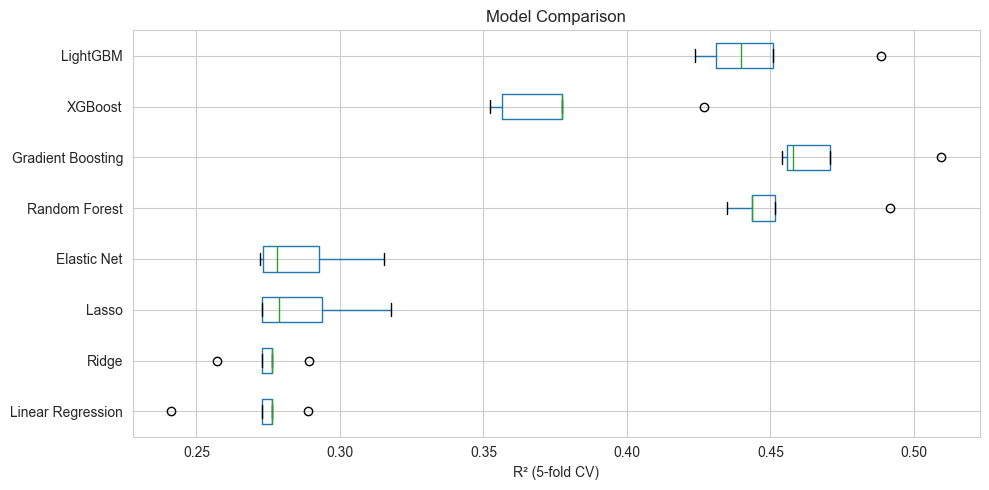

In [5]:
# Visualise results
results_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(10, 5))
results_df.boxplot(ax=ax, vert=False)
ax.set_xlabel('R² (5-fold CV)')
ax.set_title('Model Comparison')
plt.tight_layout()
plt.show()

## 2b. Additional Checks: Interaction Features
Optional consistency checks mentioned in the report.

In [6]:
from sklearn.preprocessing import PolynomialFeatures

extra_results = {}

# Manual interaction features (numeric columns only)
numeric_cols = [c for c in trn.columns if c not in ('outcome', 'cut', 'color', 'clarity')]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = poly.fit_transform(trn[numeric_cols])
interaction_model = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))])
interaction_scores = cross_val_score(interaction_model, X_inter, y, cv=kf, scoring='r2', n_jobs=-1)
extra_results['Ridge + interactions'] = interaction_scores
print(f"Ridge + interactions     R² = {interaction_scores.mean():.4f} ± {interaction_scores.std():.4f}")

results.update(extra_results)

Ridge + interactions     R² = 0.2449 ± 0.0412


## 3. Lasso Feature Importance
Using Lasso to identify which features the model considers important.

Lasso alpha: 0.0299
Non-zero coefficients: 33 / 44

Top features by |coefficient|:
      feature      coef
        depth -5.361173
           b3  2.867828
           b1  2.102203
           a1  1.909459
           a4  1.511650
cut_Very Good -1.048664
  cut_Premium -0.979731
    cut_Ideal -0.828900
     cut_Good -0.750581
        carat  0.461802
      color_G -0.281145
      color_H  0.280666
            y -0.240201
        table -0.210456
  clarity_SI1 -0.188909


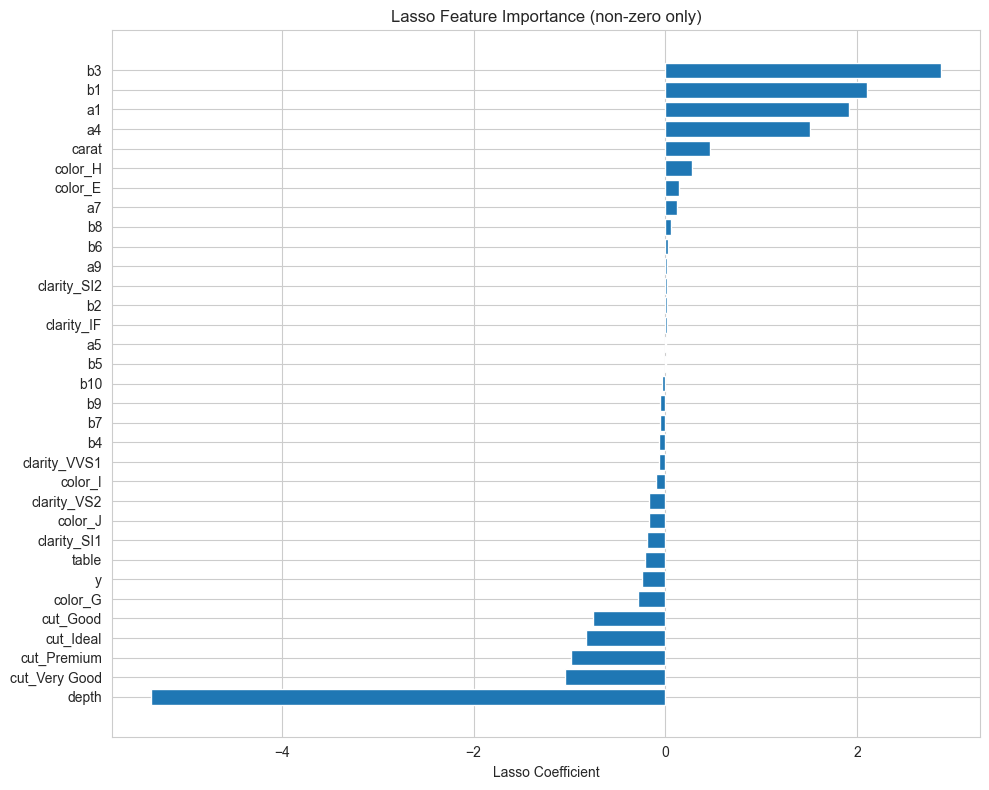

In [7]:
from sklearn.linear_model import LassoCV

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_scaled, y)

coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef': lasso_cv.coef_
}).sort_values('coef', key=abs, ascending=False)

print(f"Lasso alpha: {lasso_cv.alpha_:.4f}")
print(f"Non-zero coefficients: {(lasso_cv.coef_ != 0).sum()} / {len(lasso_cv.coef_)}")
print(f"\nTop features by |coefficient|:")
print(coef_df.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 8))
coef_df_nonzero = coef_df[coef_df['coef'] != 0].sort_values('coef')
ax.barh(coef_df_nonzero['feature'], coef_df_nonzero['coef'])
ax.set_xlabel('Lasso Coefficient')
ax.set_title('Lasso Feature Importance (non-zero only)')
plt.tight_layout()
plt.show()

## 4. Tree-Based Feature Importance
Using Random Forest and XGBoost importances as a complement to Lasso.

Random Forest Feature Importances:
feature  importance
  depth    0.348044
     b3    0.077562
     b1    0.060053
     a1    0.055993
     a4    0.038348
     a3    0.033079
     a5    0.022221
     b5    0.021812
     b2    0.021621
     a6    0.021326
     a2    0.021149
     b6    0.020758
    b10    0.020636
     b9    0.020074
     b4    0.020002


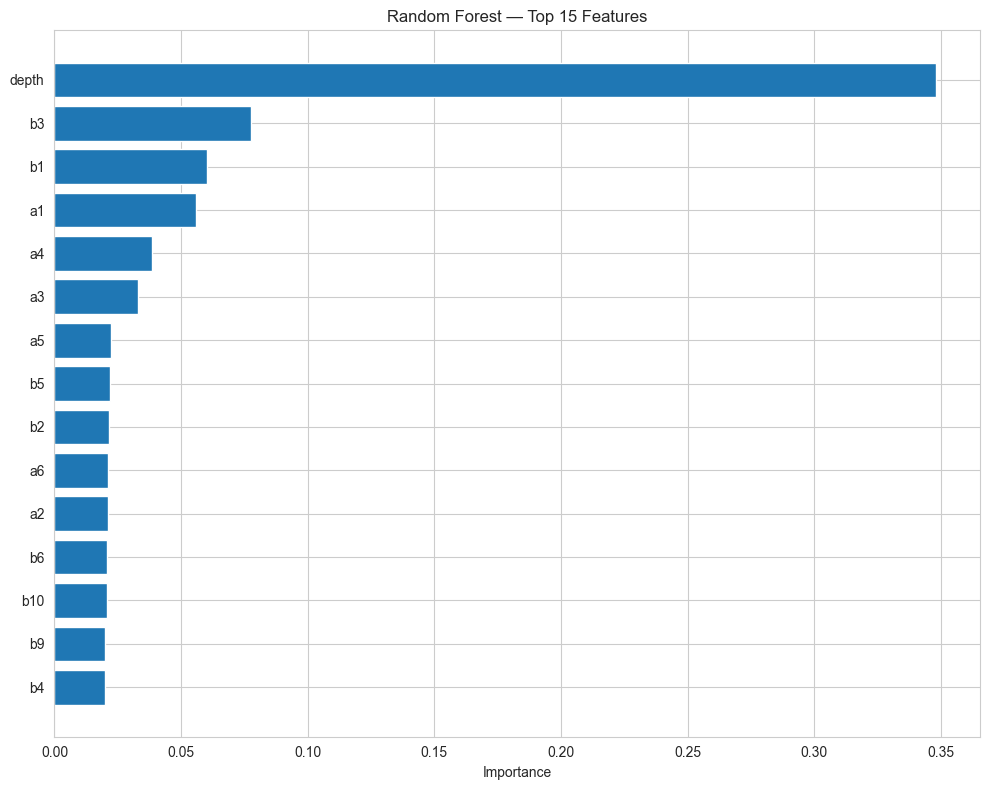

In [8]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Random Forest Feature Importances:")
print(rf_imp.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 8))
rf_imp_top = rf_imp.head(15).sort_values('importance')
ax.barh(rf_imp_top['feature'], rf_imp_top['importance'])
ax.set_xlabel('Importance')
ax.set_title('Random Forest — Top 15 Features')
plt.tight_layout()
plt.show()

## 5. Summary
Based on the above, select the top 2-3 models for hyperparameter tuning in the next notebook.

In [9]:
# Summary table
summary = pd.DataFrame({
    'Model': results.keys(),
    'Mean R²': [v.mean() for v in results.values()],
    'Std R²': [v.std() for v in results.values()]
}).sort_values('Mean R²', ascending=False).reset_index(drop=True)

print(summary.to_string(index=False))

               Model  Mean R²   Std R²
   Gradient Boosting 0.469639 0.020841
       Random Forest 0.453126 0.020063
            LightGBM 0.446852 0.022801
             XGBoost 0.378023 0.026532
               Lasso 0.287209 0.017063
         Elastic Net 0.286340 0.016197
               Ridge 0.274268 0.010274
   Linear Regression 0.271060 0.015948
Ridge + interactions 0.244922 0.041231
